In [1]:
import os
import keras
import random

2022-07-07 15:05:09.071214: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-07 15:05:09.076055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 15:05:09.076068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
classes = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}

In [3]:
import numpy as np
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import segmentation_models as sm
from utils import visualize, freeze_session
from data_loader import Dataset, Dataloader
from keras.backend import set_session
from augmentation import *

Segmentation Models: using `keras` framework.


correspondance = {0:0,1:9,2:5,3:10,4:0,5:7,6:8,7:3,8:6,9:2,10:4,11:1}

f = lambda x : correspondance[x]
vfunc = np.vectorize(f)

a = np.array([1,2,3])
vfunc = np.vectorize(f)
vfunc(a)

import cv2
import glob
import re

arr_a = glob.glob("Synthese_plus_Real/Train/images/*")
arr_i = glob.glob("Synthese_plus_Real/Valid/images/*")

for path in arr_a:
    img = cv2.imread(path)
    path = re.sub(".tiff",".png",path)
    cv2.imwrite(path,img)
    
for path in arr_i:
    img = cv2.imread(path)
    path = re.sub(".tiff",".png",path)
    cv2.imwrite(path,img)

%cd Synthese_plus_Real

import shutil

for i in arr:
    ibis = i + 250
    shutil.copyfile("images/{}.png".format(str(i)),"Train/images/{}.png".format(str(ibis)))
    shutil.copyfile("masks/{}.png".format(str(i)),"Train/masks/{}.png".format(str(ibis)))

In [15]:
# Tensorflow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

train_dir = "Synthese_plus_Real/Train/"
test_dir = "Real/Valid/"
result_dir = "Synthese_plus_Real/Result/"
image_size = 512
image_channels = 3
padding_size = 800
n_classes = 12

# model parameters
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
LR = 0.0005
EPOCHS = 100
activation ='softmax'

2022-07-07 15:09:53.181532: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
x_train_dir = os.path.join(train_dir, 'images')
y_train_dir = os.path.join(train_dir, 'masks')
x_valid_dir = os.path.join(test_dir, 'images')
y_valid_dir = os.path.join(test_dir, 'masks')


# define network parameters 
preprocess_input = sm.get_preprocessing(BACKBONE)

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=n_classes, 
    augmentation=False,
    preprocessing=get_preprocessing(preprocess_input),
    #preprocessing=False,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=n_classes, 
    augmentation=False,
    preprocessing=get_preprocessing(preprocess_input),
    #preprocessing=False,
)

/home/hugo/new_ampli/env/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [10]:
#create model
model = sm.Unet(BACKBONE,classes=n_classes, activation=activation)

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(n_classes)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

2022-07-07 15:08:47.618274: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
BATCH_SIZE = 8
#Dataloaders
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, image_size, image_size, image_channels)
assert train_dataloader[0][1].shape == (BATCH_SIZE, image_size, image_size, n_classes)


In [16]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(result_dir,'best_model.h5'), save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

#model.load_weights('Synthese2/Result/best_model.h5')

# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100
45/45 [==============================] - 376s 8s/step - loss: 0.8639 - iou_score: 0.1134 - f1-score: 0.1430 - val_loss: 0.9380 - val_iou_score: 0.2772 - val_f1-score: 0.2830 - lr: 5.0000e-04
Epoch 2/100
45/45 [==============================] - 352s 8s/step - loss: 0.7162 - iou_score: 0.2606 - f1-score: 0.3257 - val_loss: 0.9019 - val_iou_score: 0.3281 - val_f1-score: 0.3504 - lr: 5.0000e-04
Epoch 3/100
45/45 [==============================] - 350s 8s/step - loss: 0.5921 - iou_score: 0.4176 - f1-score: 0.5115 - val_loss: 0.8665 - val_iou_score: 0.3322 - val_f1-score: 0.3677 - lr: 5.0000e-04
Epoch 4/100
45/45 [==============================] - 345s 8s/step - loss: 0.5185 - iou_score: 0.4782 - f1-score: 0.5694 - val_loss: 0.8664 - val_iou_score: 0.3358 - val_f1-score: 0.3699 - lr: 5.0000e-04
Epoch 5/100
45/45 [==============================] - 348s 8s/step - loss: 0.4660 - iou_score: 0.5181 - f1-score: 0.6047 - val_loss: 0.8416 - val_iou_score: 0.3581 - val_f1-score: 0.3933 - 

45/45 [==============================] - 389s 9s/step - loss: 0.1821 - iou_score: 0.7816 - f1-score: 0.8351 - val_loss: 0.7943 - val_iou_score: 0.4330 - val_f1-score: 0.4736 - lr: 5.0000e-04
Epoch 42/100
45/45 [==============================] - 387s 9s/step - loss: 0.1776 - iou_score: 0.7950 - f1-score: 0.8469 - val_loss: 0.7909 - val_iou_score: 0.4480 - val_f1-score: 0.4881 - lr: 5.0000e-04
Epoch 43/100
45/45 [==============================] - 390s 9s/step - loss: 0.1785 - iou_score: 0.7875 - f1-score: 0.8400 - val_loss: 0.7899 - val_iou_score: 0.4286 - val_f1-score: 0.4689 - lr: 5.0000e-04
Epoch 44/100
45/45 [==============================] - 391s 9s/step - loss: 0.1757 - iou_score: 0.7926 - f1-score: 0.8449 - val_loss: 0.7928 - val_iou_score: 0.4327 - val_f1-score: 0.4742 - lr: 5.0000e-04
Epoch 45/100
45/45 [==============================] - 391s 9s/step - loss: 0.1758 - iou_score: 0.7975 - f1-score: 0.8509 - val_loss: 0.7918 - val_iou_score: 0.4197 - val_f1-score: 0.4606 - lr: 5.00

45/45 [==============================] - 388s 9s/step - loss: 0.1429 - iou_score: 0.8395 - f1-score: 0.8829 - val_loss: 0.7941 - val_iou_score: 0.4308 - val_f1-score: 0.4729 - lr: 5.0000e-04
Epoch 82/100
45/45 [==============================] - 386s 9s/step - loss: 0.1425 - iou_score: 0.8331 - f1-score: 0.8755 - val_loss: 0.8127 - val_iou_score: 0.3867 - val_f1-score: 0.4286 - lr: 5.0000e-04
Epoch 83/100
45/45 [==============================] - 388s 9s/step - loss: 0.1450 - iou_score: 0.8298 - f1-score: 0.8734 - val_loss: 0.7996 - val_iou_score: 0.4275 - val_f1-score: 0.4687 - lr: 5.0000e-04
Epoch 84/100
45/45 [==============================] - 390s 9s/step - loss: 0.1394 - iou_score: 0.8407 - f1-score: 0.8824 - val_loss: 0.7869 - val_iou_score: 0.4387 - val_f1-score: 0.4804 - lr: 5.0000e-04
Epoch 85/100
45/45 [==============================] - 390s 9s/step - loss: 0.1397 - iou_score: 0.8440 - f1-score: 0.8856 - val_loss: 0.8003 - val_iou_score: 0.4196 - val_f1-score: 0.4614 - lr: 5.00

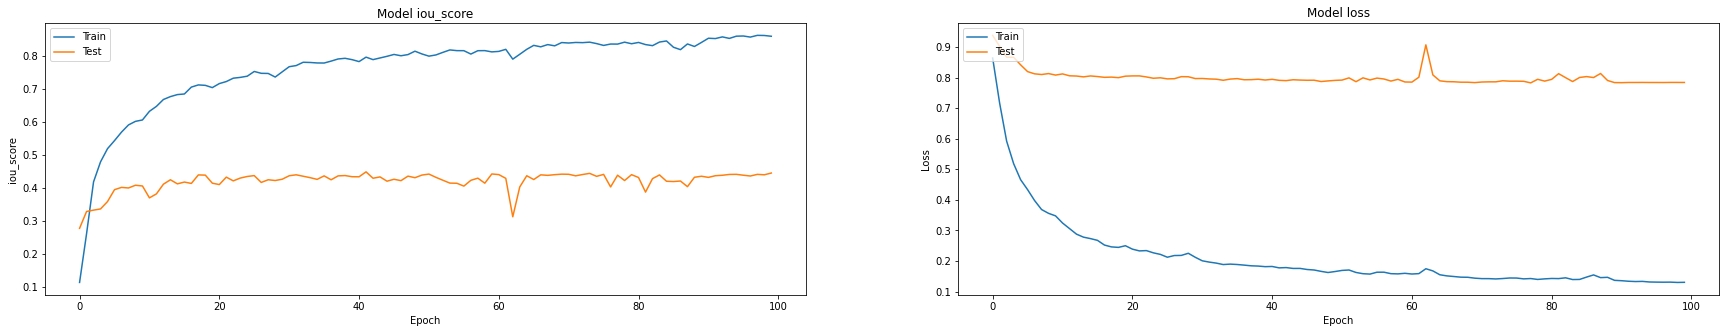

In [17]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(result_dir,'UNET-Training.png'))
plt.show()

#Save model as Tensorflow frozen graph
#frozen_graph = freeze_session(K.get_session(),output_names=[out.op.name for out in model.outputs])
#tf.train.write_graph(frozen_graph, result_dir , "best_model.pb", as_text=False)

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17092444597943790182
xla_global_id: -1
]


2022-07-08 08:44:59.632594: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
model.load_weights(os.path.join(result_dir,'best_model.h5'))

In [20]:
valid_imgs=[]
valid_labels=[]

for img,label in valid_dataset:
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

In [21]:
predictions = model.predict(valid_imgs)

2/2 [==============================] - 21s 8s/step


In [22]:
valid_labels.shape

(64, 512, 512, 12)

In [23]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


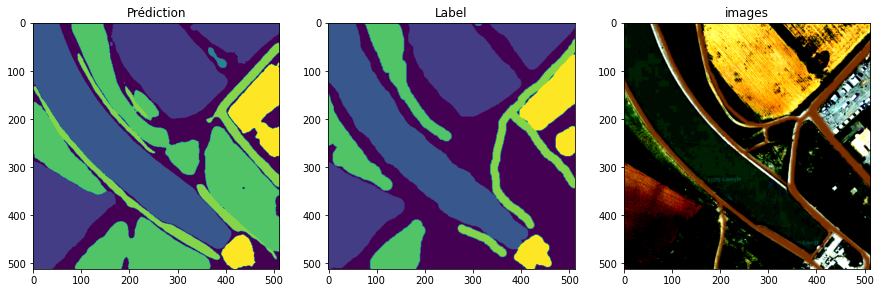

In [24]:
i=random.choice(range(len(valid_imgs)-1))
print(i)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(label_pred[i])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(true_label[i])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(valid_imgs[i])
plt.gca().set_title("images")
plt.show()

In [25]:
np.unique(valid_labels)

array([0., 1.])

In [26]:
np.unique(label_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Avec seuil

In [ ]:
ious = []
threshold_iou = [0.01,0.05,0.1,0.15,0.2,
                 0.25,0.3,0.35,0.4,0.45,0.5,
                 0.55,0.6,0.65,0.7,0.75,0.8]

for threshold in threshold_iou:
    iou = []
    for idx_classe in range(1,11):
        prediction = np.where(predictions[...,idx_classe]<= threshold,0,1)
        target = valid_labels[...,idx_classe]

        intersection = np.logical_and(target,prediction)
        union = np.logical_or(target,prediction)
        iou_score = np.sum(intersection) / np.sum(union)

        # print("iou score for class", classes[idx_classe], ": with 0.5 threshold ",iou_score)
        iou.append(iou_score)
    ious.append(np.mean(iou))
    
plt.plot(threshold_iou,ious)
plt.gca().set_title("Finding best confidence threshold for class except background")
plt.show()

In [ ]:
best_threshold = 0.5

In [ ]:
conf_mat = np.zeros((11,11))

for idx_pred_class in range(11):
    for idx_target_class in range(11):
        prediction = np.where(predictions[...,idx_pred_class]<= best_threshold,0,1)
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,prediction)
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [ ]:
(np.sum(conf_mat.flatten()) - len(valid_imgs)*SIZE[0]*SIZE[1]) / 

### Avec l'Argmax

In [27]:
classes = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}
classe = list(classes.values())

In [28]:
prediction = np.zeros(predictions.shape)

for idx_class in range(11):
    prediction[...,idx_class][label_pred == idx_class] = 1

In [29]:
iou = {}
for idx_classe in range(11):
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction[...,idx_classe])
    union = np.logical_or(target,prediction[...,idx_classe])
    iou_score = np.sum(intersection) / np.sum(union)

    iou[classe[idx_classe]] = iou_score
print(iou)
    
print("mIou: ", np.mean(list(iou.values())))

{'falaise': 0.3658081971209574, 'batiment': 0.594756700829271, 'route': 0.8740119048343856, 'pierrier': 0.878249774300331, 'verger': 0.33729473684210526, 'champ': 0.7535252939306216, 'prairie': 0.4821235553696191, 'foret': 0.4915540016343757, 'foret_claire': 0.6761785959193237, 'buisson': 0.636453318502226, 'eau': 0.9220904033572126}
mIou:  0.6374587711491299


In [30]:
conf_mat = np.zeros((11,11))

for idx_pred_class in range(11):
    for idx_target_class in range(11):
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,prediction[...,idx_pred_class])
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [ ]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), classe, rotation='vertical')
plt.yticks(range(11), classe, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de confusion avec le nombre d'effectifs", fontsize=25)
plt.show()
plt.show()

In [ ]:
conf_mat_norm = conf_mat.T/conf_mat.sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), classe, rotation='vertical')
plt.yticks(range(11), classe, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()
plt.show()

In [ ]:
conf_mat_norm_bis = conf_mat / conf_mat.sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), classe, rotation='vertical')
plt.yticks(range(11), classe, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()
plt.show()

In [ ]:
dico = {}
for key in classes:
    precision = conf_mat[key,key]/np.sum(conf_mat[key,:])
    recall = conf_mat[key,key]/np.sum(conf_mat[:,key])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classes[key]] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

In [ ]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

## Modèle entrainé sur le jeu de synthese testé sur le Jeu de validation Réelle

In [ ]:
real_dir = "Real/Valid/"

x_valid_dir = os.path.join(real_dir, 'images')
y_valid_dir = os.path.join(real_dir, 'masks')

# Dataset for validation images
valid_dataset_real = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=12, 
    augmentation=False,
    preprocessing=get_preprocessing(preprocess_input),
    #preprocessing=False,
)

In [ ]:
model.load_weights(os.path.join(result_dir,'best_model.h5'))

In [ ]:
valid_imgs_real =[]
valid_labels_real =[]

for img,label in valid_dataset_real:
    valid_imgs_real.append(img)
    valid_labels_real.append(label)
    
valid_imgs_real = np.array(valid_imgs_real)
valid_labels_real = np.array(valid_labels_real)


In [ ]:
predictions = model.predict(valid_imgs_real)

In [ ]:
classes_real = {0:"background",1:"buisson",2:"champ",3:"eau",
         4:"falaise",5:"foret",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}

correspondance = {1:9,2:5,3:10,4:0,5:7,6:8,7:3,8:6,9:2,10:4,11:1}

In [ ]:
valid_labels_real.shape,predictions.shape

In [ ]:
true_label = np.argmax(valid_labels_real,axis=3)
label_pred = np.argmax(predictions,axis=3)

In [ ]:
i=random.choice(range(len(valid_imgs_real)-1))
#i = 48
print(i)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(label_pred[i])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(true_label[i])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(valid_imgs_real[i])
plt.gca().set_title("images")
plt.show()

In [ ]:
prediction = np.zeros(predictions.shape)

for idx_class in range(11):
    prediction[...,idx_class][label_pred == idx_class] = 1

In [ ]:
a

In [ ]:
iou = {}

a = list(classes_real.values())

for idx_classe in range(1,12):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels_real[...,idx_classe]

    intersection = np.logical_and(target,prediction[...,correspondance[idx_classe]])
    union = np.logical_or(target,prediction[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score
print(iou)
    
print("mIou: ", np.mean(list(iou.values())))

In [ ]:
conf_mat = np.zeros((11,12))

for idx_pred_class in range(1,12):
    for idx_target_class in range(0,12):
        target = valid_labels_real[...,idx_target_class]
        
        intersection = np.logical_and(target,prediction[...,correspondance[idx_pred_class]])
        conf_mat[idx_pred_class-1,idx_target_class] = np.sum(intersection)

In [ ]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)+1):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), list(classes_real.values()), rotation='vertical')
plt.yticks(range(11), list(classes_real.values())[1:], rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de Confusion réalisé avec les effectifs", fontsize=25)
plt.show()

In [ ]:
assert np.sum(conf_mat.flatten())/len(label_pred.flatten()) == 1

In [ ]:
conf_mat_norm = conf_mat[:,1:].T/conf_mat[:,1:].sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), list(classes_real.values())[1:], rotation='vertical')
plt.yticks(range(11), list(classes_real.values())[1:], rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()

In [ ]:
conf_mat_norm_bis = conf_mat[:,1:] / conf_mat[:,1:].sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(11):
    for j in range(11):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), list(classes_real.values())[1:], rotation='vertical')
plt.yticks(range(11), list(classes_real.values())[1:], rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()

In [ ]:
conf_mat_without_background = conf_mat[:,1:]
conf_mat_without_background.shape

In [ ]:
dico = {}
for key in range(11):
    precision = conf_mat_without_background[key,key]/np.sum(conf_mat_without_background[key,:])
    recall = conf_mat_without_background[key,key]/np.sum(conf_mat_without_background[:,key])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classes_real[key+1]] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

In [ ]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))